In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib.pyplot import *
from seaborn import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# loading the data from csv file to a Pandas DataFrame
df = pd.read_csv('insurance.csv')




ModuleNotFoundError: No module named 'pandas'

In [28]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [27]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [16]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [17]:
df.duplicated().sum()

1

In [18]:
df.drop_duplicates(inplace=True)

We performed duplicate and null checks.
We removed the duplicate rows.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [43]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: >

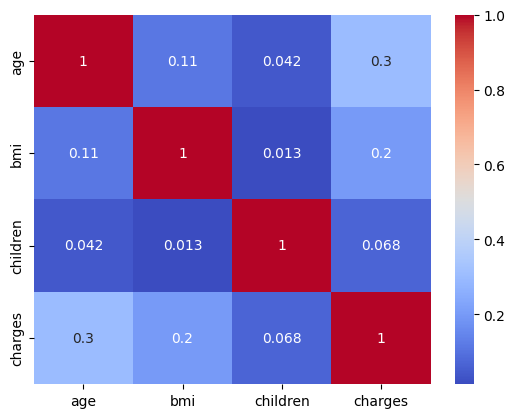

In [44]:
num_categories = [feature for feature in df.columns if df[feature].dtype != "O"]
corr = df[num_categories].corr()
sns.heatmap(corr, cmap = 'coolwarm', annot= True)

<ipython-input-45-7a76e8017688>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-45-7a76e8017688>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




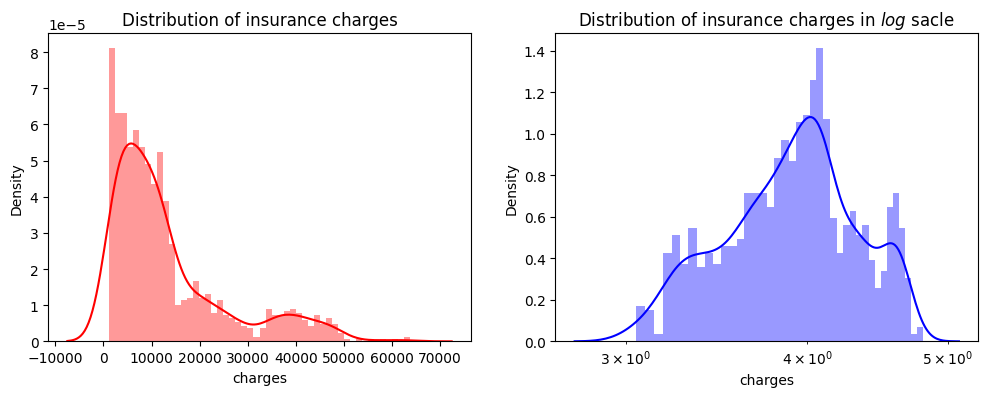

In [45]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['charges'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance charges')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['charges']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance charges in $log$ sacle')
ax.set_xscale('log');

In [34]:
categorical_columns = ['sex','children', 'smoker', 'region']
data_encode = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')

In [35]:
## Log transform
data_encode['charges'] = np.log(data_encode['charges'])

In [5]:
df['sex'].value_counts()


male      676
female    662
Name: sex, dtype: int64

In [37]:
import plotly.express as px

data_numerical = df[['age', 'bmi', 'children']]
labels = ['Age', 'BMI', 'Children']

fig = px.box(data_numerical, labels=labels)
fig.update_layout(title='Boxplot of Age, BMI, and Children',
                  xaxis_title='Variables', yaxis_title='Values')

From the above we can see that:

The Age column is mostly balanced! It has a normal distribution as the mediun line lies betwen 25 and 75 percentile value!
The bmi column is balanced but it has some outliers. We see the dots above the bmi.
The children one is right skewed or positively skewed. More than 50% people have 0 or 1 children with max children = 5.
Now lets understand the target column:

In [46]:
#Handling outliers via IQR method via Capping (Since we are not targetting any data loss)
data2 = df.copy()

#for BMI
q1 = np.percentile(df['bmi'], 25)
q3 = np.percentile(df['bmi'], 75)
iqr = q3 - q1

lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr

cleaned_data = []
for value in df['bmi']:
    if value < lower_limit:
        cleaned_data.append(lower_limit)
    elif value > upper_limit:
        cleaned_data.append(upper_limit)
    else:
        cleaned_data.append(value)

data2['bmi'] =  cleaned_data

#for charges
q1 = np.percentile(df['charges'], 25)
q3 = np.percentile(df['charges'], 75)
iqr = q3 - q1

lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr

cleaned_data = []
for value in df['charges']:
    if value < lower_limit:
        cleaned_data.append(lower_limit)
    elif value > upper_limit:
        cleaned_data.append(upper_limit)
    else:
        cleaned_data.append(value)

data2['charges'] =  cleaned_data

In [47]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

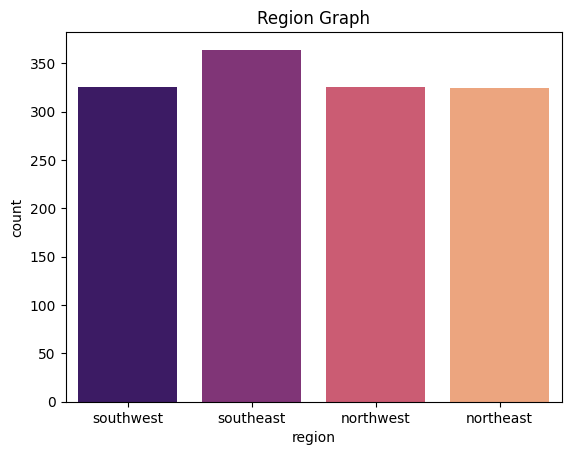

In [48]:
countplot(x = 'region', data = df, palette = 'magma')
title('Region Graph')
show()

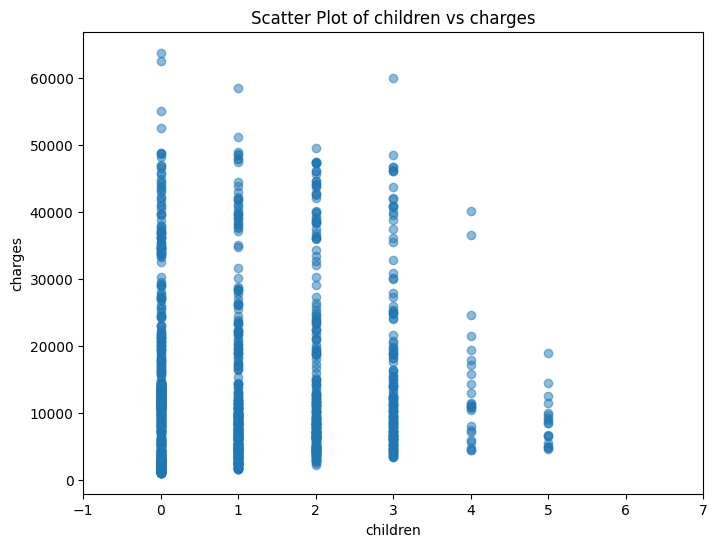

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(df['children'], df['charges'], alpha=0.5)
plt.xlim(-1, 7)
plt.title('Scatter Plot of children vs charges')
plt.xlabel('children')
plt.ylabel('charges')
plt.show()

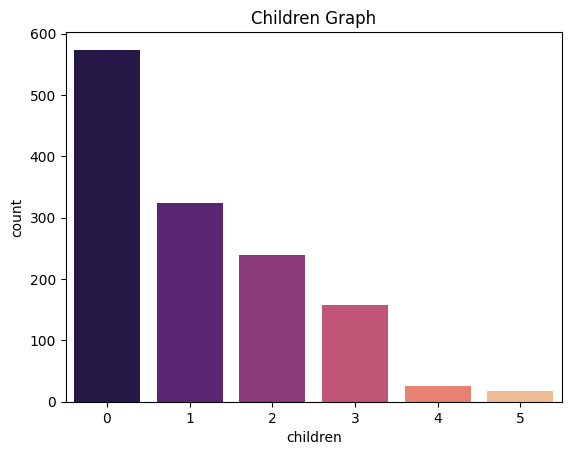

In [12]:
countplot(x = 'children', data = df, palette = 'magma')
title('Children Graph')
show()

As we have seen before, most parents have 0 or 1 children. We see as the number of kids incresing the health insurance cost contribution decreases! The indivual with 4 or 5 kids have lesser contribution than a 0 or 1 kid contributor.

In [13]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [51]:
ct1 = pd.crosstab(df['sex'], df['smoker'], margins=True, margins_name="Total")

ct1

smoker,no,yes,Total
sex,,,
female,547,115,662
male,517,159,676
Total,1064,274,1338


18% of Women smoke and 21% of Men smoke

In [50]:
ct = pd.crosstab(df['children'], df['smoker'], margins=True, margins_name="Total")

ct

smoker,no,yes,Total
children,,,
0,459,115,574
1,263,61,324
2,185,55,240
3,118,39,157
4,22,3,25
5,17,1,18
Total,1064,274,1338


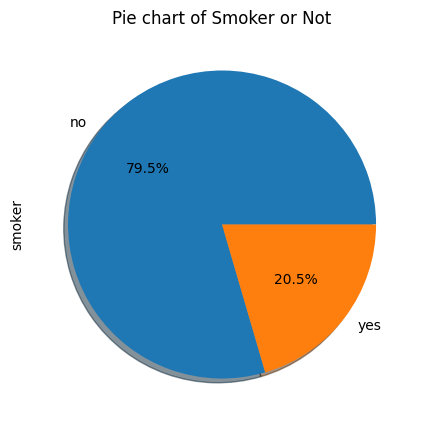

In [7]:
figure(figsize=(12,6))
df['smoker'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(5,5))
title("Pie chart of Smoker or Not")
show()

In [52]:
data_numerical = data2[['bmi']]
labels = ['BMI']

fig = px.box(data_numerical, labels=labels)
fig.update_layout(title='Boxplot of BMI with outlier handled',
                  xaxis_title='bmi', yaxis_title='Values')
fig.show()

data_numerical = data2[['charges']]
labels = ['charges']

fig = px.box(data_numerical, labels=labels)
fig.update_layout(title='Boxplot of Charges with outlier handled',
                  xaxis_title='charges', yaxis_title='Values')
fig.show()

Since regression depends on weaights of the coefficients, its better to scale the numerical columns

In [53]:
#Label encoding
from sklearn.preprocessing import LabelEncoder
sex_encoder = LabelEncoder()
region_encoder = LabelEncoder()
smoker_encoder = LabelEncoder()

data2['sex'] = sex_encoder.fit_transform(data2['sex'])
data2['region'] = region_encoder.fit_transform(data2['region'])
data2['smoker'] = smoker_encoder.fit_transform(data2['smoker'])

data2.head()


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [64]:
#Scaling Numerical columns!
from sklearn.preprocessing import MinMaxScaler
data21 = data2.copy()
scaler = MinMaxScaler()
scaler.fit(data21['bmi'].values.reshape(-1,1))
data21['bmi'] = scaler.fit_transform(data21['bmi'].values.reshape(-1,1))
scaler.fit(data21['age'].values.reshape(-1,1))
data21['age'] = scaler.fit_transform(data21['age'].values.reshape(-1,1))
scaler.fit(data2['charges'].values.reshape(-1,1))
data21['charges'] = scaler.fit_transform(data21['charges'].values.reshape(-1,1))

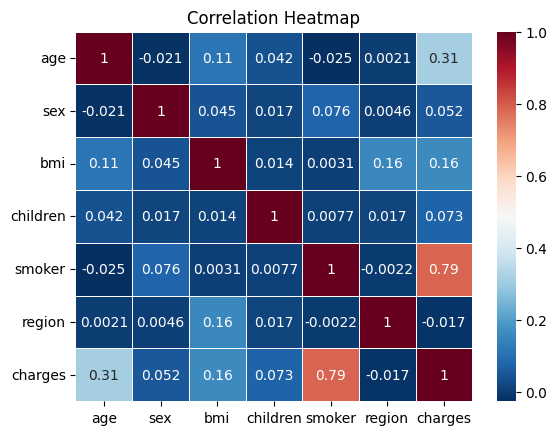

In [56]:
#Checking Correlation between the variables using a heatmap!
corr = data21.corr()
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap='RdBu_r',
           annot=True,
           linewidth=0.5)

plt.title("Correlation Heatmap")
plt.show()

In [42]:
# The Target Column(y) = charges has a positive correlation with "smoker" and rest have a "negative" correlations.

# Now we are done with preprocessing the files, we can move forward with the data modeling. At this stage, we are done with:

# Missing value imputation - Not required!
# Understanding the data via visualizations and distribution analysis with EDA
# Detected and handled outliers
# Label Encoding the categorical columns
#Scaling the features with lots of variability like age, BMI and charges

<Axes: xlabel='age', ylabel='Count'>

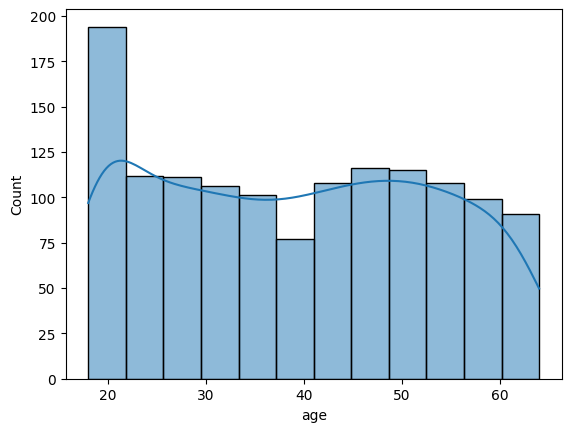

In [14]:
histplot(df['age'], kde=True)

<Axes: xlabel='bmi', ylabel='Count'>

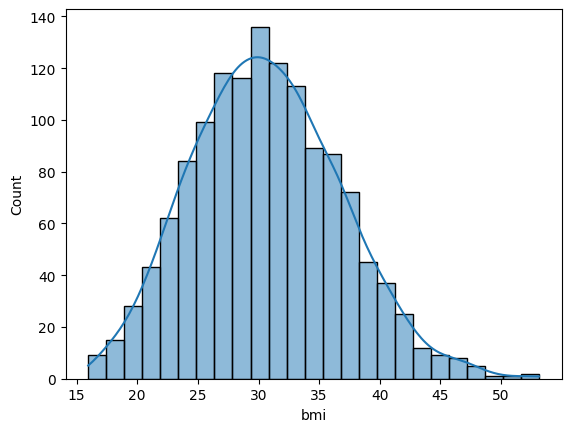

In [15]:
histplot(df['bmi'], kde=True)

In [65]:
X = data21.drop(columns='charges', axis=1)
Y = data21['charges']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [66]:
# Loading the Linear Regression model
regressor = LinearRegression()

# Fitting the model on the scaled data
regressor.fit(X_train, Y_train)

# Prediction on training data
training_data_prediction = regressor.predict(X_train)

# R squared value for training data
r2_train = metrics.r2_score(Y_train, training_data_prediction)
print('R squared value for training data:', r2_train)

# Prediction on test data
test_data_prediction = regressor.predict(X_test)

# R squared value for test data
r2_test = metrics.r2_score(Y_test, test_data_prediction)
print('R squared value for test data:', r2_test)

R squared value for training data: 0.7451600880393663
R squared value for test data: 0.7559809496230534


In [67]:
# AdaBoost Regression with Hyperparameter Tuning
# Define the parameter grid for hyperparameter tuning
ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Create AdaBoostRegressor
ada_model = AdaBoostRegressor(random_state=42)

# Create GridSearchCV object for AdaBoost
ada_grid_search = GridSearchCV(ada_model, ada_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
ada_grid_search.fit(X_train, Y_train)

# Get the best parameters from the grid search for AdaBoost
best_ada_params = ada_grid_search.best_params_

# Print the best parameters for AdaBoost
print(f'Best Parameters for AdaBoost: {best_ada_params}')

Best Parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 50}


In [68]:
# Use the best parameters to create the final AdaBoost model
final_ada_model = AdaBoostRegressor(n_estimators=best_ada_params['n_estimators'],
                                    learning_rate=best_ada_params['learning_rate'],
                                    random_state=42)

# Fitting the final model on the scaled data
final_ada_model.fit(X_train,  Y_train)

# Prediction on training data
ada_training_data_prediction = final_ada_model.predict(X_train)

# R squared value for AdaBoost training data
ada_r2_train = metrics.r2_score(Y_train, ada_training_data_prediction)
print('AdaBoost R squared value for training data:', ada_r2_train)

# Prediction on test data
ada_test_data_prediction = final_ada_model.predict(X_test)

# R squared value for AdaBoost test data
ada_r2_test = metrics.r2_score(Y_test, ada_test_data_prediction)
print('AdaBoost R squared value for test data:', ada_r2_test)

# Calculate Mean Squared Error
mse_final_ada = metrics.mean_squared_error(Y_test, ada_test_data_prediction)
print('Mean Squared Error (Final AdaBoost):', mse_final_ada)

AdaBoost R squared value for training data: 0.821518844389734
AdaBoost R squared value for test data: 0.8287348366458237
Mean Squared Error (Final AdaBoost): 0.016014984544834337
